# Rescaled Range Analysis

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set_theme()
import backtrader as bt
from backtrader.feeds import PandasData
import warnings
warnings.filterwarnings('ignore')

## Fetch Data from Pickle files

In [4]:
# read spot data
df_spot = pd.read_pickle('../data/overall.pkl')

# read perp data
df_perp = pd.read_pickle('../data/perp_overall.pkl')

print(df_spot.ticker.unique(), df_perp.ticker.unique(), df_spot.columns)

['BINANCE_SPOT_BTC_USDT' 'BINANCE_SPOT_ETH_USDT' 'BINANCE_SPOT_BNB_USDT'
 'BINANCE_SPOT_ADA_USDT' 'BINANCE_SPOT_XRP_USDT' 'BINANCE_SPOT_MATIC_USDT'
 'BINANCE_SPOT_SOL_USDT' 'BINANCE_SPOT_UNI_USDT' 'BINANCE_SPOT_AVAX_USDT'] ['BINANCEFTS_PERP_BTC_USDT' 'BINANCEFTS_PERP_ADA_USDT'
 'BINANCEFTS_PERP_ETH_USDT' 'BINANCEFTS_PERP_XRP_USDT'
 'BINANCEFTS_PERP_DOGE_USDT' 'BINANCEFTS_PERP_SOL_USDT'
 'BINANCEFTS_PERP_UNI_USDT' 'BINANCEFTS_PERP_AVAX_USDT'
 'BINANCEFTS_PERP_MATIC_USDT' 'BINANCEFTS_PERP_BNB_USDT'] Index(['time_period_start', 'time_period_end', 'time_open', 'time_close',
       'price_open', 'price_high', 'price_low', 'price_close', 'volume_traded',
       'trades_count', 'ticker'],
      dtype='object')


In [185]:
df_spot

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count,ticker
0,2020-10-27 04:00:00+00:00,2020-10-27 05:00:00+00:00,2020-10-27 04:00:00.179000+00:00,2020-10-27 04:59:59.773000+00:00,13083.24,13125.00,13083.24,13124.60,1100.816862,15977,BINANCE_SPOT_BTC_USDT
1,2020-10-27 05:00:00+00:00,2020-10-27 06:00:00+00:00,2020-10-27 05:00:01.035000+00:00,2020-10-27 05:59:59.856000+00:00,13124.61,13144.49,13080.24,13088.65,1447.336487,19319,BINANCE_SPOT_BTC_USDT
2,2020-10-27 06:00:00+00:00,2020-10-27 07:00:00+00:00,2020-10-27 06:00:00.608000+00:00,2020-10-27 06:59:58.388000+00:00,13088.66,13106.09,13061.01,13106.09,1570.109937,19349,BINANCE_SPOT_BTC_USDT
3,2020-10-27 07:00:00+00:00,2020-10-27 08:00:00+00:00,2020-10-27 07:00:00.340000+00:00,2020-10-27 07:59:59.989000+00:00,13106.08,13160.00,13086.97,13144.58,2602.515018,26664,BINANCE_SPOT_BTC_USDT
4,2020-10-27 08:00:00+00:00,2020-10-27 09:00:00+00:00,2020-10-27 08:00:00.129000+00:00,2020-10-27 08:59:59.600000+00:00,13144.59,13170.21,13125.00,13141.56,2226.309279,33975,BINANCE_SPOT_BTC_USDT
...,...,...,...,...,...,...,...,...,...,...,...
145692,2022-08-31 03:00:00+00:00,2022-08-31 04:00:00+00:00,2022-08-31 03:00:00.789000+00:00,2022-08-31 03:59:56.895000+00:00,19.78,19.97,19.77,19.81,86885.360000,3834,BINANCE_SPOT_AVAX_USDT
145693,2022-08-31 04:00:00+00:00,2022-08-31 05:00:00+00:00,2022-08-31 04:00:00.205000+00:00,2022-08-31 04:59:52.679000+00:00,19.80,19.89,19.69,19.70,102132.780000,3445,BINANCE_SPOT_AVAX_USDT
145694,2022-08-31 05:00:00+00:00,2022-08-31 06:00:00+00:00,2022-08-31 05:00:00.996000+00:00,2022-08-31 05:59:56.301000+00:00,19.70,19.87,19.66,19.80,76343.660000,3193,BINANCE_SPOT_AVAX_USDT
145695,2022-08-31 06:00:00+00:00,2022-08-31 07:00:00+00:00,2022-08-31 06:00:01.745000+00:00,2022-08-31 06:59:55.370000+00:00,19.81,20.07,19.58,19.64,280801.860000,9443,BINANCE_SPOT_AVAX_USDT


In [176]:
## choose the ticker inside the dataframe
def get_backtest_ticker_df(df: pd.DataFrame, ticker: str, start_dt: str, end_dt: str, with_returns=True) -> pd.DataFrame:
    data = df.loc[(df['ticker'] == ticker) & (df['time_period_start'] >= start_dt) & (df['time_period_start'] <= end_dt)]
    data = data[['time_period_start', 'price_open', 'price_high', 'price_low', 'price_close', 'volume_traded']]
    data.columns = ['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume']
    data.set_index('DateTime', inplace=True)
    if with_returns: data['ret'] = data['Close'].pct_change()

    return data

In [182]:
get_backtest_ticker_df(df_spot, ticker='BINANCE_SPOT_BTC_USDT', start_dt='2020-11-01', end_dt='2021-01-01').head()

,Open,High,Low,Close,Volume,ret
DateTime,,,,,,
2020-11-01 00:00:00+00:00,13791.00,13895.00,13660.00,13725.95,3504.288678,NaN
2020-11-01 01:00:00+00:00,13725.96,13772.02,13707.68,13759.90,971.786119,0.002473
2020-11-01 02:00:00+00:00,13759.91,13774.96,13686.14,13715.88,903.824302,-0.003199
2020-11-01 03:00:00+00:00,13715.88,13733.90,13641.00,13690.01,1170.788245,-0.001886
2020-11-01 04:00:00+00:00,13690.01,13701.05,13603.00,13677.25,1557.090698,-0.000932


In [184]:
get_backtest_ticker_df(df_perp, ticker='BINANCEFTS_PERP_BTC_USDT', start_dt='2020-11-01', end_dt='2021-01-01', with_returns=False).head()

,Open,High,Low,Close,Volume
DateTime,,,,,
2020-11-01 00:00:00+00:00,13783.73,13891.52,13653.00,13720.66,23570.687
2020-11-01 01:00:00+00:00,13720.01,13763.14,13699.99,13749.99,5568.987
2020-11-01 02:00:00+00:00,13749.99,13765.00,13681.98,13708.39,5149.473
2020-11-01 03:00:00+00:00,13708.39,13727.90,13628.37,13680.13,8501.398
2020-11-01 04:00:00+00:00,13680.13,13694.72,13605.90,13666.99,6970.417


#### Timeseries required (example)
1. Generate initial Hurst exp (H_0) using one month worth of 1hr data (672 datapoints). Use entire november data to generate H_0
2. Then, generate Hurst exp time series from H_0 for the month of Dec. This will result in 672 1hr data points of Hurst exp for Dec.
3. We need to feed in 3 times series into the back tester (all in Dec):
    - Price series of underlying 
    - Price series of perp swap
    - Hurst exp
4. Create strategy for mean reversion:
    - start trading only when hurst is below 0.5 (mean reverting)
    - incorporate bollinger bands to make hurst strat more robust

## Strategy
When price is inside Bollinger Band (BB):
- H > 0.5 -> hedge by long/short perp in opposite direction of underlying
- if rebound from upper BB + H < 0.5 -> short underlying
- if rebound from lower BB + H < 0.5 -> long underlying

When price is above Bollinger band:
- if H > 0.5 -> inaction
- if H < 0.5 + cross BB -> short underlying

When price is below Bollinger band
- if H > 0.5 -> inaction
- if H < 0.5 + cross BB -> long underlying

In general, when price is outside BB, take action only when H < 0.5 (mean reverting). When inside BB, hedge with perp in opposite direction only when H > 0.5 (trending)

#### Detrended Fluctuation Analysis (DFA)
https://raposa.trade/blog/find-your-best-market-to-trade-with-the-hurst-exponent/

#### Rescaled Range (R/S) Analysis (rolling window)

In [133]:
# hurst exponent through rescaled range
def hurst_rs(ts):
    ts = np.array(ts)
    # N is use for storge the length sequence
    total_len, rescaled_range, ts_len = [], [], len(ts)
    while True:
        total_len.append(ts_len)
        # calculate mean 
        m = np.mean(ts)
        # calculate mean deviation
        mean_dev = ts - m
        # Construct cumulative deviation sequence
        cumulative_dvi = np.cumsum(mean_dev)
        # Calculate max_diff
        max_diff = max(cumulative_dvi) - min(cumulative_dvi)
        # Calculate the unbiased standard deviation of this sequence
        unbiased_std_dvi = np.std(ts)
        # Calculate the rescaled range of this sequence under n length
        rescaled_range.append(max_diff / unbiased_std_dvi)
        # While n < 4 then break
        if ts_len < 4:
            break
        # Rebuild this sequence by half length
        ts, ts_len = half_series(ts, ts_len)
        # Get Hurst-index by fit log(RS)~log(n)
        hurst_slope = np.polyfit(np.log10(total_len), np.log10(rescaled_range), 1)[0]
    return hurst_slope

# helper function for hurst_slope
def half_series(s, n):
# ''' if length(X) is odd: X <- {(X1 + X2) / 2, ..., (Xn-2 + Xn-1) / 2, Xn} n <- (n - 1) / 2 else: X <- {(X1 + X2) / 2, ..., (Xn-1 + Xn) / 2} n <- n / 2 return X, n '''
    x = []
    for i in range(0, len(s) - 1, 2):
        x.append((s[i] + s[i + 1]) / 2)
    # if length(s) is odd
        if len(s) % 2 != 0:
            x.append(s[-1])
            n = (n - 1) // 2
        else:
            n = n // 2
    return [np.array(x), n]

## Wrangle for Backtest Data

In [231]:
def get_all_backtest_ticker_dict(df_spot: pd.DataFrame, df_perp: pd.DataFrame, start_dt: str, end_dt: str) -> dict:
    backtest_dict = {spot_ticker.split('_')[2]: {
        'spot': get_backtest_ticker_df(df_spot, ticker=spot_ticker, start_dt=start_dt, end_dt=end_dt),
        'perp': get_backtest_ticker_df(df_perp, ticker=perp_ticker, start_dt=start_dt, end_dt=end_dt, with_returns=False)
    } for spot_ticker, perp_ticker in zip(df_spot.ticker.unique(), df_perp.ticker.unique())}
    
    return backtest_dict

In [250]:
backtest_dict = get_all_backtest_ticker_dict(
    df_spot, df_perp, start_dt='2020-11-01', end_dt='2022-08-01')

In [249]:
def get_all_backtest_ticker_with_hurst_dict(backtest_dict, rolling_window):
    ticker_list = list(backtest_dict.keys())
    for ticker in ticker_list:
        df = backtest_dict[ticker]['spot']
        df[f'hurst_{rolling_window}'] = df['Close'].rolling(rolling_window).apply(hurst_rs)

    return backtest_dict

In [252]:
placeholder_dict = get_all_backtest_ticker_with_hurst_dict(
    backtest_dict=backtest_dict,
    rolling_window=int(3*24)
)

<AxesSubplot:xlabel='DateTime'>

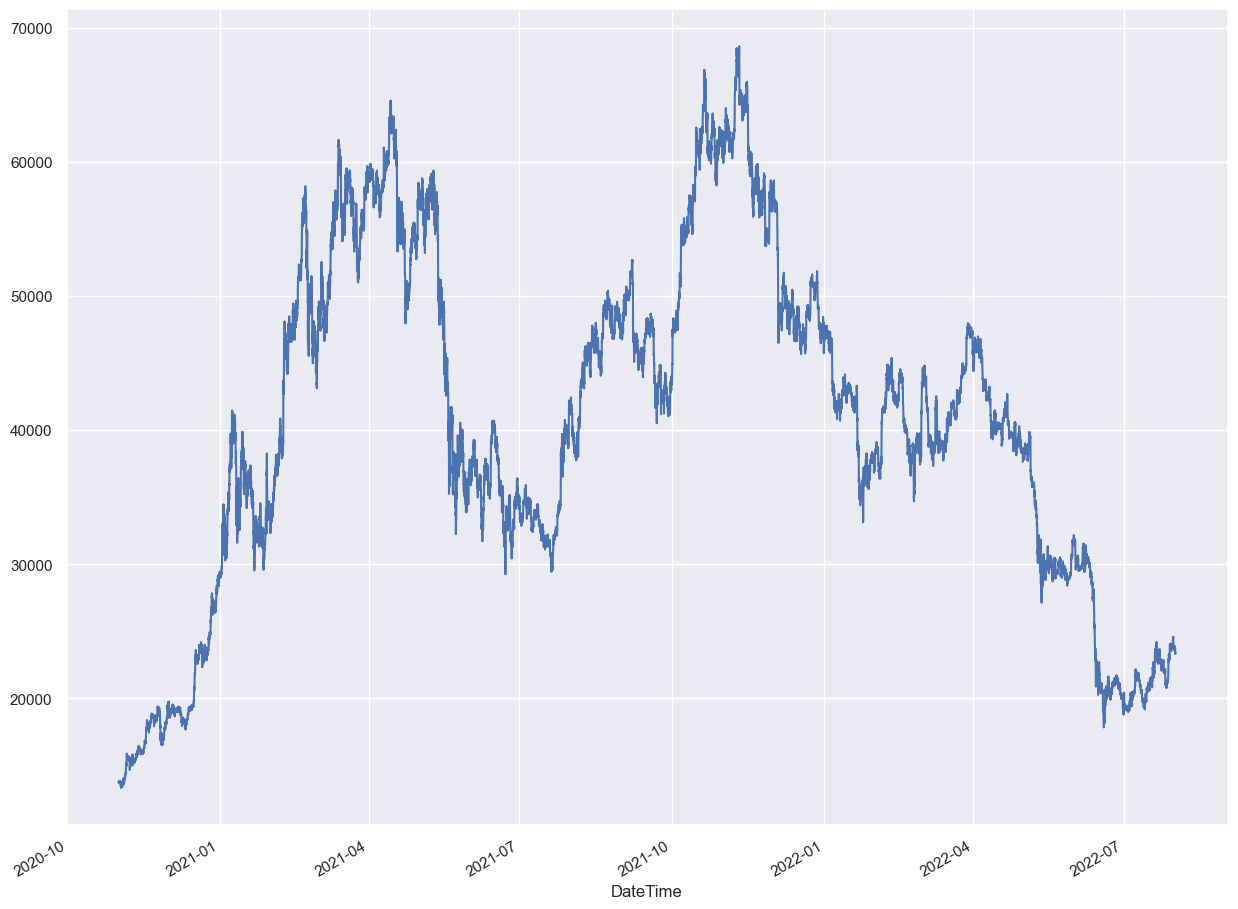

In [258]:
placeholder_dict['BTC']['spot']['Close'].plot()

<AxesSubplot:xlabel='DateTime'>

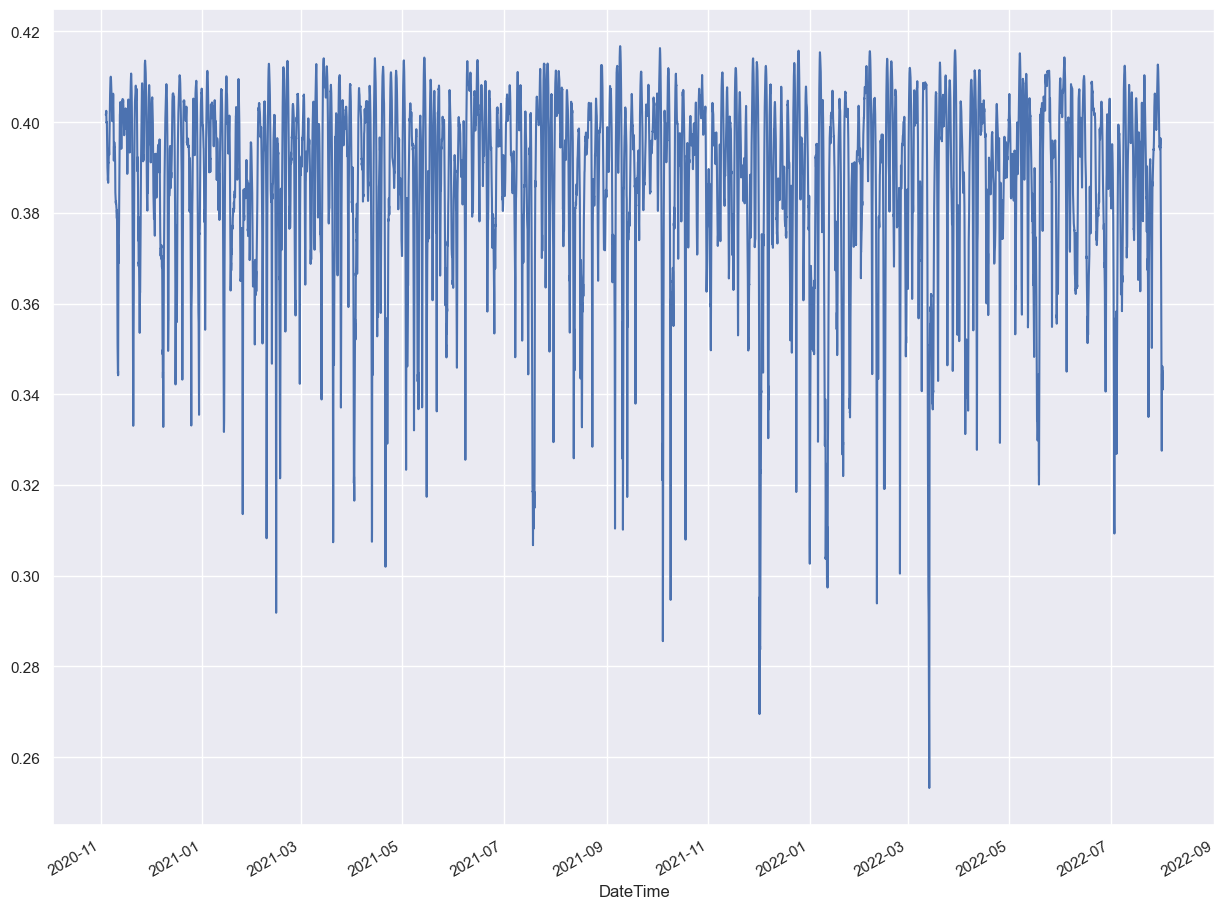

In [254]:
placeholder_dict['BTC']['spot']['hurst_72'].plot()

- Choose the number of points for rolling window for hurst (for 1, 2, 3, 6 months, or no. of days)
- Compare rolling window 

In [237]:
def hurst_rolling(df, rolling_window):
    df[f'hurst_{rolling_window}'] = df['Close'].rolling(rolling_window).apply(hurst_rs)
    return df 

In [239]:
hurst_rolling(backtest_dict['MATIC']['spot'], rolling_window=int(3*24))

,Open,High,Low,Close,Volume,ret,hurst_72
DateTime,,,,,,,
2020-11-01 00:00:00+00:00,0.01371,0.01379,0.01355,0.01366,3561906.3,NaN,NaN
2020-11-01 01:00:00+00:00,0.01369,0.01379,0.01365,0.01378,4877741.2,0.008785,NaN
2020-11-01 02:00:00+00:00,0.01378,0.01404,0.01376,0.01385,6796354.3,0.005080,NaN
2020-11-01 03:00:00+00:00,0.01385,0.01387,0.01379,0.01380,1479335.9,-0.003610,NaN
2020-11-01 04:00:00+00:00,0.01381,0.01389,0.01371,0.01389,1759445.7,0.006522,NaN
...,...,...,...,...,...,...,...
2022-07-31 20:00:00+00:00,0.95230,0.95580,0.94520,0.95340,2337128.3,0.001155,0.363809
2022-07-31 21:00:00+00:00,0.95350,0.95440,0.93790,0.93930,2533016.5,-0.014789,0.362938
2022-07-31 22:00:00+00:00,0.93920,0.93960,0.91070,0.92530,9033442.1,-0.014905,0.358357


In [221]:
eth_df['hurst_rs'] = eth_df['Close'].rolling(10000).apply(hurst_rs)

### Testing cerebro for btc-usdt

In [123]:
# https://www.backtrader.com/docu/pandas-datafeed/pandas-datafeed/
# 
class PandasData(bt.feeds.PandasData):
    lines = ('ret', 'hurst_rs', )
    params = (
        ('ret', 'ret'),
        ('hurst_rs', 'hurst_rs')
    )
    datafields = bt.feeds.PandasData.datafields + (['ret', 'hurst_rs'])

class HurstExp(bt.Indicator):
    lines = ('hurst',)

    def __init__(self):
        self.lines.hurst = self.data.hurst_rs
    
class St(bt.Strategy):
    def __init__(self):
        # self.sma = bt.indicators.SimpleMovingAverage(self.data)
        self.bb = bt.indicators.BollingerBands(self.data)
        self.hurst = HurstExp(self.data)

In [124]:
cerebro = bt.Cerebro()

# data1 = PandasData(dataname=proper_btc)
# cerebro.adddata(data1)

data = PandasData(dataname=btc_df_for_backtrader)
cerebro.adddata(data)

cerebro.addstrategy(St)
cerebro.run()

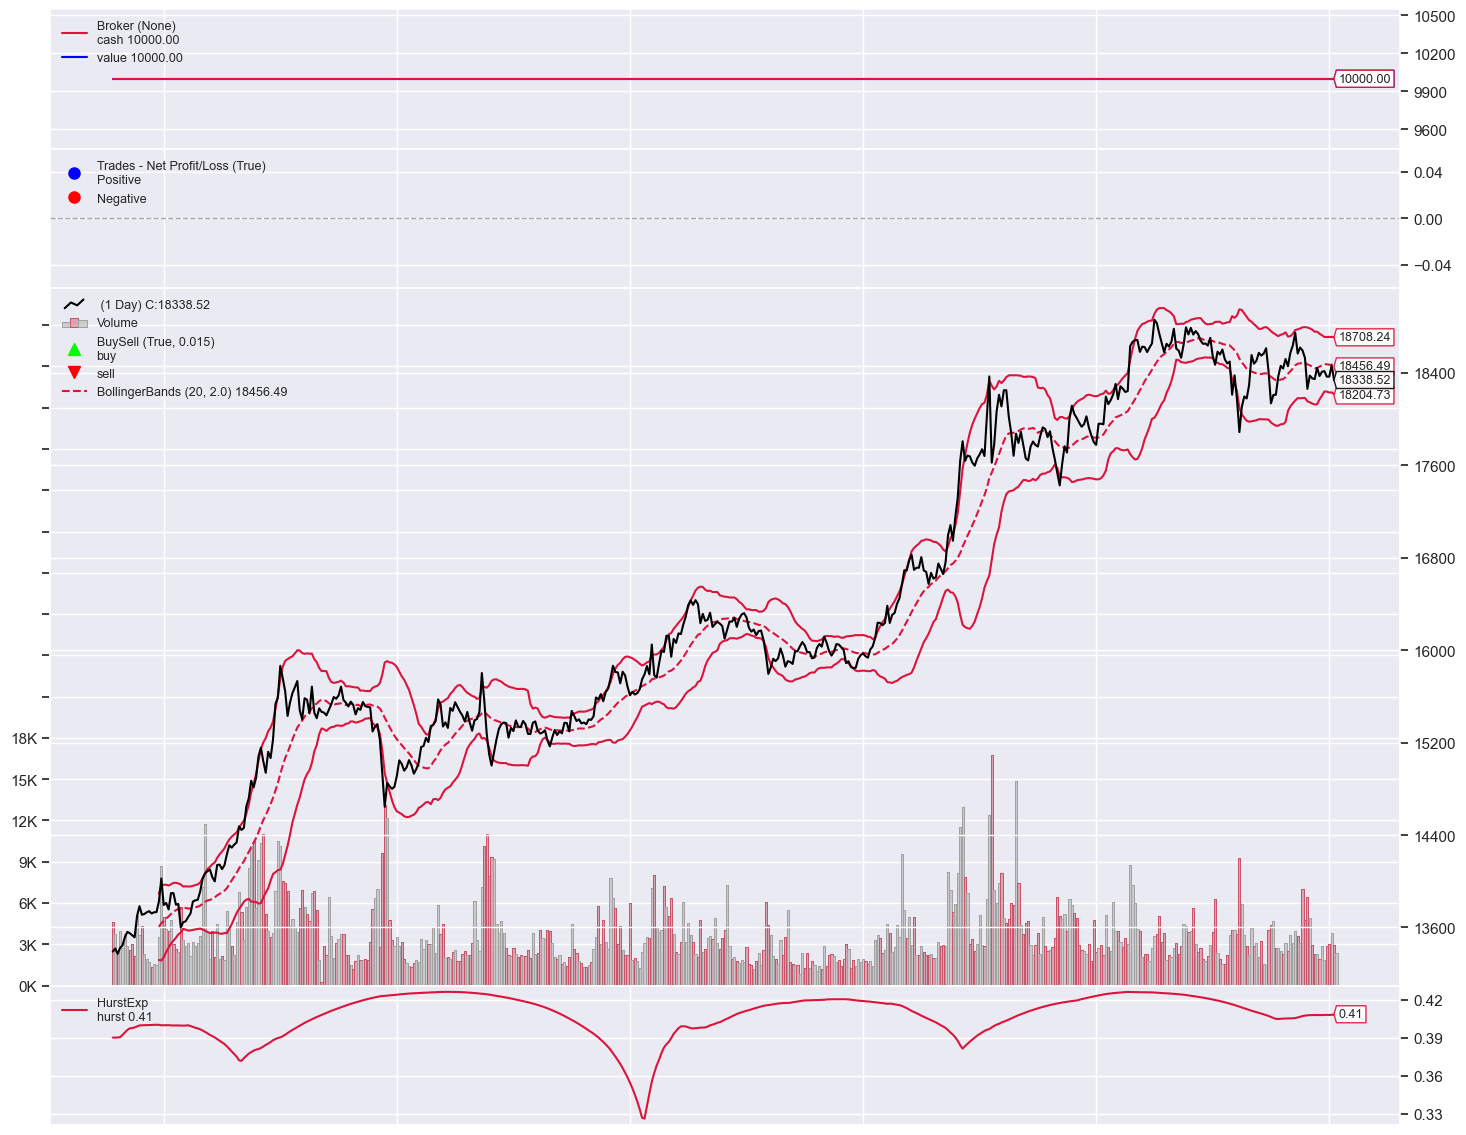

[[<Figure size 1500x1200 with 5 Axes>]]

In [125]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 12]
cerebro.plot(iplot=False)
# plt.rcParams.update({'font.size': 12}) 
# cerebro.plot(volume=False, iplot = False)

Hurst exponent = 0.3 for the Nov-2020 for btc_usdt
- likely to reverse trend over time?